Training machine learning models for classification tasks can be highly beneficial across numerous applications and fields.

For deep neural networks, Residual Networks (ResNets) are particularly relevant due to their unique architecture. This architecture, consisting of convolutional layers combined with "shortcut" connections, effectively addresses the vanishing/exploding gradient problem. Common examples of ResNets include ResNet18, ResNet50, ResNet101, and ResNet152.

In the next steps, I'll use the available dataset [here](https://www.kaggle.com/datasets/alessiocorrado99/animals10?select=translate.py) to classify animal images into one of 10 categories, employing a ResNet18 model.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

### Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as T
import torchvision.datasets as datasets
import torchvision.models as models

from torch.utils.data import DataLoader, sampler, Subset, Dataset, random_split
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

2025-07-07 19:58:14.393043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751918294.673089      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751918294.759849      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# For reproducibility

def set_all_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

MY_SEED = 5
set_all_seeds(MY_SEED)

### Data Loading and Preprocessing

In [ ]:
data_path = r"/kaggle/input/animals10/raw-img/"

categorical_targets = sorted(os.listdir(data_path))
targets_with_index = {target: i for i, target in enumerate(categorical_targets)}
indexed_targets = torch.tensor([targets_with_index[target] for target in categorical_targets])

print(f'Targets and its index: {targets_with_index}')
print(indexed_targets)

Targets and its index: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [ ]:
file = r"/kaggle/input/animals10/translate.py"
content = {}

with open(file, "r") as f:
    content = f.read()

categories = json.loads(content.split(" = ")[1])

print((categories))
print(len(categories))


{'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo'}
17


In [ ]:
def english_target(italian_target):
    for target, translation in categories.items():
        if italian_target == target:
            return translation
        elif italian_target == 'ragno':
            return 'spider'
    return "No match"


new_categories = {}


for target_in_italian, index in targets_with_index.items():
    target = english_target(target_in_italian)
    new_categories[index] = target


print(new_categories)

{0: 'dog', 1: 'horse', 2: 'elephant', 3: 'butterfly', 4: 'chicken', 5: 'cat', 6: 'cow', 7: 'sheep', 8: 'spider', 9: 'squirrel'}


In [ ]:
target_transform = T.Lambda(lambda indexed_targets: torch.tensor([float(indexed_targets)]))


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [ ]:
data = datasets.ImageFolder(root=Path(data_path), transform=transform, target_transform=target_transform)
print(f'Total elements in dataset: {len(data)}')

Total elements in dataset: 26179


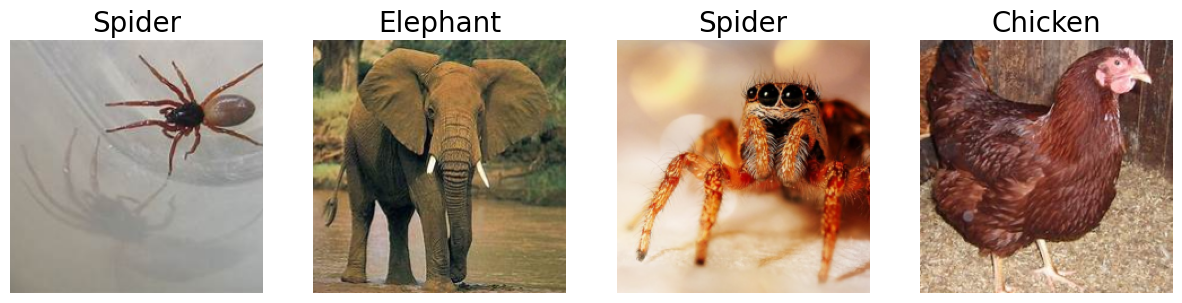

In [ ]:
# Examples of Images from the Dataset
mean_tensor = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std_tensor = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

indices = [random.randint(0,len(data)) for index in range(4)]

fig, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(len(indices)):
    img = data[indices[i]][0] * std_tensor + mean_tensor
    axs[i].imshow(img.permute(1,2,0))
    axs[i].set_title(f'{new_categories.get(int(data[indices[i]][1].item()), "Unknown").capitalize()}', fontsize=20)
    axs[i].axis('off')
plt.show()

#### Split the dataset into training, validation, and test sets.

In [ ]:
train_data, valid_data, test_data = random_split(data, [0.7, 0.15, 0.15])

In [ ]:
# Dataloaders

batch_size = 16

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

valid_dataloader = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using {device} device')

Using cpu device


### Model

In [ ]:
model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

### Train

In [ ]:
def train(dataloader, model, optimizer):
    accum_loss = 0
    accum_accuracy = 0
    model.train()

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        y = y.squeeze(1).to(torch.long)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        accum_loss += loss.item()*y.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y).float()
        accum_accuracy += is_correct.sum().item()

    epoch_loss = accum_loss / len(dataloader.dataset)
    epoch_accuracy = accum_accuracy / len(dataloader.dataset)

    print(f" Train loss: {epoch_loss:>0.5}")
    print(f" Train accuracy: {(100*epoch_accuracy):>0.1f}%")

    return epoch_loss, epoch_accuracy

In [ ]:
def validation(dataloader, model):
    accum_loss = 0
    accum_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = y.squeeze(1).to(torch.long)
            loss = loss_fn(pred.squeeze(1), y)
            accum_loss += loss.item()*y.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y).float()
            accum_accuracy += is_correct.sum().item()

    epoch_loss = accum_loss / len(dataloader.dataset)
    epoch_accuracy = accum_accuracy / len(dataloader.dataset)

    print(f" Validation loss: {epoch_loss:>0.5}")
    print(f" Validation accuracy: {(100*epoch_accuracy):>0.1f}%")

    return epoch_loss, epoch_accuracy

In [ ]:
epochs = 5
loss_hist_train = []
acc_hist_train = []
loss_hist_val = []
acc_hist_val = []

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}\n---------------------')
    loss_train, accuracy_train = train(train_dataloader, model, optimizer)
    loss_hist_train.append(loss_train)
    acc_hist_train.append(accuracy_train)

    loss_val, accuracy_val = validation(valid_dataloader, model)
    loss_hist_val.append(loss_val)
    acc_hist_val.append(accuracy_val)


Epoch 1
---------------------
 Train loss: 0.58324
 Train accuracy: 88.1%
 Validation loss: 0.32295
 Validation accuracy: 94.5%

Epoch 2
---------------------
 Train loss: 0.57673
 Train accuracy: 90.9%
 Validation loss: 0.46669
 Validation accuracy: 93.6%

Epoch 3
---------------------
 Train loss: 0.61279
 Train accuracy: 91.6%
 Validation loss: 0.55131
 Validation accuracy: 93.2%

Epoch 4
---------------------
 Train loss: 0.63818
 Train accuracy: 91.4%
 Validation loss: 0.43071
 Validation accuracy: 94.7%

Epoch 5
---------------------
 Train loss: 0.63424
 Train accuracy: 92.2%
 Validation loss: 0.4996
 Validation accuracy: 94.2%


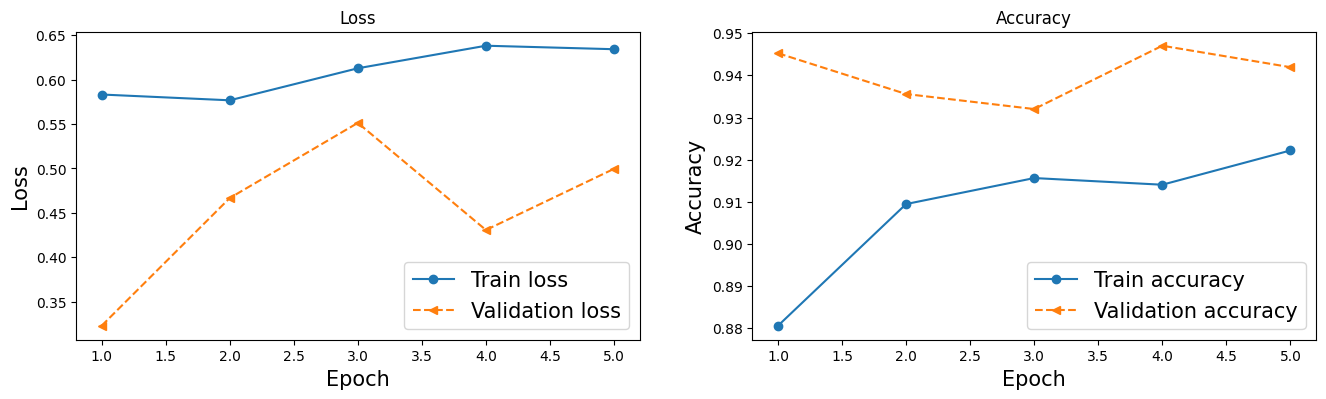

In [ ]:
fig = plt.figure(figsize=(16,4))
x_axis = np.arange(1, epochs + 1)
f1 = fig.add_subplot(1, 2, 1)

f1.set_ylabel("Loss", size=15)
f1.set_xlabel("Epoch", size=15)
f1.set_title("Loss")
f1.plot(x_axis, loss_hist_train, '-o', label='Train loss')
f1.plot(x_axis, loss_hist_val, '--<', label='Validation loss')
f1.legend(fontsize=15)

f1 = fig.add_subplot(1, 2, 2)
f1.set_ylabel("Accuracy", size=15)
f1.set_xlabel("Epoch", size=15)
f1.set_title("Accuracy")
f1.plot(x_axis, acc_hist_train, '-o', label='Train accuracy')
f1.plot(x_axis, acc_hist_val, '--<', label='Validation accuracy')
f1.legend(fontsize=15)

plt.show()

### Test

In [ ]:
 def test(dataloader, model):
    accum_accuracy = 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = y.squeeze(1).to(torch.long)
            is_correct = (torch.argmax(pred, dim=1) == y).float()
            accum_accuracy += is_correct.sum().item()

    epoch_accuracy = accum_accuracy / len(dataloader.dataset)
    return epoch_accuracy

In [ ]:
accuracy = test(test_dataloader, model)

print(f"Accuracy = {100*accuracy:>0.2f} %")

Accuracy = 94.68 %


### Save model

In [ ]:
save_path = r'/kaggle/working/IC10AC_models_weights.pth'

torch.save(model.state_dict(), save_path)


In [ ]:
!ls /kaggle/working/

IC10AC_models_weights.pth
